In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)
df.columns = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Class label']
display(df.head())

X = df[['Petal length', 'Petal width']].values
y = pd.factorize(df['Class label'])[0]

# discard exmaples in the first class
X = X[50:150]
y = np.where(y[50:150] == 2, -1, y[50:150])

# split training and testing data(20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# Standardization for Gradient Descent
std = StandardScaler()
std.fit(X_train)
X_train_std = std.transform(X_train)
X_test_std = std.transform(X_test)

print('#Training data points: %d' % X_train.shape[0])
print('#testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))

,Sepal length,Sepal width,Petal length,Petal width,Class label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


#Training data points: 80
#testing data points: 20
Class labels: [-1  1]


In [4]:
from numpy.random import seed

class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int
        Set random state for shuffling and initializing the weights.
        
    """
    def __init__(self, eta=0.01, batch_size=1, n_iter=50, shuffle=True, random_state=1):
        self.eta = eta
        self.batch_size = batch_size
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state:
            seed(random_state)
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        batch_num = X.shape[0] // self.batch_size
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for b in range(batch_num):
                X_batch, target_batch = self.next_batch(X, y, b)
                cost.append(self._update_weights(X_batch, target_batch))
            avg_cost = sum(cost)
            self.cost_.append(avg_cost)
        return self

    def next_batch(self, X, y, i):
        return X[i*self.batch_size:i*self.batch_size+self.batch_size], y[i*self.batch_size:i*self.batch_size+self.batch_size]
    
    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Randomly initialize weights"""
        self.w_ = np.random.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(xi)
        error = (target - output)
        self.w_[1:] += self.eta * xi.T.dot(error)
        self.w_[0] += self.eta * error.sum()
        cost = (error**2).sum() * 0.5
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)


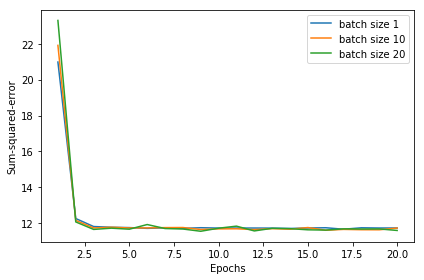

Misclassified samples: 1
Accuracy: 0.95
Misclassified samples: 1
Accuracy: 0.95
Misclassified samples: 1
Accuracy: 0.95


In [5]:
adas1 = AdalineSGD(eta=0.01, batch_size=1, n_iter=20, random_state=1)
adas1.fit(X_train_std, y_train)
adas2 = AdalineSGD(eta=0.01, batch_size=10, n_iter=20, random_state=1)
adas2.fit(X_train_std, y_train)
adas3 = AdalineSGD(eta=0.01, batch_size=20, n_iter=20, random_state=1)
adas3.fit(X_train_std, y_train)

plt.plot(range(1, len(adas1.cost_) + 1), adas1.cost_, label='batch size 1')
plt.plot(range(1, len(adas2.cost_) + 1), adas2.cost_, label='batch size 10')
plt.plot(range(1, len(adas3.cost_) + 1), adas3.cost_, label='batch size 20')

plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('Lab04-1_104000033.png', dpi=300)
plt.show()

y_pred = adas1.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

y_pred = adas2.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

y_pred = adas3.predict(X_test_std)
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))